In [ ]:
!pip install pytrends

In [78]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pytrends.request import TrendReq

sns.set_theme()

## Jak używać google trends?

Załóżmy, że interesują nas dwa słowa kluczowe: *fontanna ogrodowa* oraz *fontanna pokojowa*, w okresie od 1 stycznia 2018 do 1 kwietnia 2021:

In [74]:
# key words list
kw_list = ['fontanna ogrodowa', 'fontanna pokojowa']

pytrends = TrendReq()
pytrends.build_payload(kw_list = kw_list, timeframe='2018-01-01 2021-04-01', geo='PL')

Teraz kiedy mammy obiekt pytrends, możemy pobrać względną liczbę wyszukań tych słów

In [75]:
trends = pytrends.interest_over_time()

Metoda interest_over_time() zwraca słownik, w którym kluczami są elementy listy kw_list (słowa kluczowe) zaś wartościami są pandas.Series().

In [76]:
trends['fontanna ogrodowa']

date
2018-01-07     0
2018-01-14     5
2018-01-21     0
2018-01-28     5
2018-02-04    21
              ..
2021-02-28     5
2021-03-07    18
2021-03-14    26
2021-03-21    27
2021-03-28    19
Name: fontanna ogrodowa, Length: 169, dtype: int32

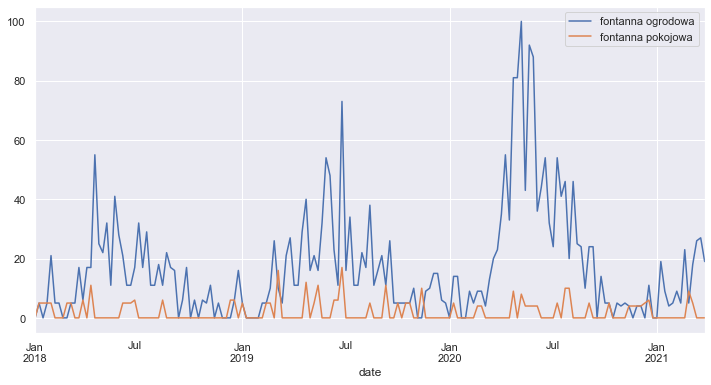

In [92]:
plt.figure(figsize = (12,6))
for key in kw_list:
    trends[key].plot(label=key)
plt.legend()
plt.show()

Dane są reprezentowane w odstępnach tygodniowych. Liczby na osi Y prezentują *względą* liczbę zapytań - 100 oznacza maksimum zapytań w danym okresie czasu, dla danych słów kluczowych.

Jeśli chcemy, możemy oczywiście łatwo zagregować dane w dłuższe okresy czasu, np. kolejne miesiące:

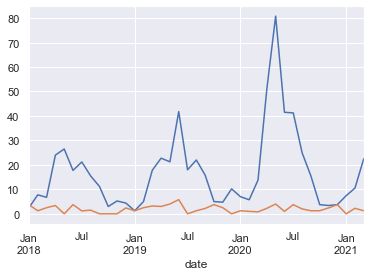

In [93]:
freq = 'MS'
for key in kw_list:
    trends[key].resample(freq).mean().plot(label=key)

lub lata:

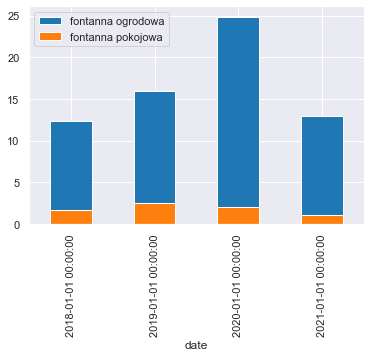

In [114]:
freq = 'YS'
colors = ['#1f77b4', '#ff7f0e']

for key, col in zip(kw_list, colors):
    trends[key].resample(freq).mean().plot(label=key, kind='bar', color=col)
plt.legend()
plt.show()

## Porównanie google trends oraz sprzedaży Shumee

In [9]:
with open('./data/clustered_products.json') as json_file:
    clustered_products = json.load(json_file)
    
df = pd.read_excel('./data/shumee_mckinsey -Aktualizacja 01.03.xlsx', index_col=None, engine='openpyxl')

In [119]:
# The first day Shumee started gathering the data
first_day = df["Data"].dt.date.min()
# The last day
last_day = df["Data"].dt.date.max()

dti_weeks = pd.date_range(start=first_day, end=last_day, freq="W")

In [7]:
clustered_products

[['Basenik z fontanną dla ptaków, zielony, 50x91 cm,',
  'shumee Fontanna czekoladowa, stal nierdzewna, srebrna, 250 W',
  'Fontanna czekoladowa, stal nierdzewna, srebrna, 60',
  'Fontanna czekoladowa, stal nierdzewna, srebrna, 25',
  'Fontanna czekoladowa PERVOI, 60 W',
  'Fontanna czekoladowa PERVOI, 250 W',
  'Fontanna czekoladowa, stal nierdzewna, czarna, 60',
  'Fontanna czekoladowa, stal nierdzewna, czarna, 60 W',
  'Fontanna do basenu, stal nierdzewna, 64 x 30 x 52 cm, srebrna',
  'Fontanna do basenu, stal nierdzewna, 50 x 30 x 90 cm, srebrna',
  'Fontanna do basenu, stal nierdzewna, 64 x 30 x 52',
  'Fontanna do basenu, stal nierdzewna, 30 x 9 x 26 c',
  'Fontanna do basenu, stal nierdzewna, 50 x 30 x 53',
  'Fontanna do basenu, stal nierdzewna, 45 x 30 x 65',
  'Fontanna do basenu LED, 15,8x11,8x24 cm',
  'Fontanna do basenu LED, 22,5x17x25,5 cm',
  'Fontanna do basenu LED, 13,5x13,5x18,5 cm',
  'Fontanna do basenu z LED, stal nierdzewna, 30x60x4',
  'Fontanna ze stali nierdze

Mam tutaj jedną uwagę - pierwszy klaster (fontanny) wygląda bardzo spoko, ale oprócz fontann do basenu zawiera też coś całkiem innego - fontannę czekoladową, która jednak powinna się znaleźć w innej kategorii. Podobnie nie jestem pewny, czy fontanna ogrodowa i pokojowa to ta sama kategoria.

In [126]:
cluster_number = 0

sells = df[df["Nazwa produktu"].map(lambda x: x in clustered_products[cluster_number])]

sells = sells.groupby(df["Data"].dt.date)["ID zamówienia"].nunique()
sells = sells.reindex(dti_weeks, fill_value = 0)

In [128]:
pytrends = TrendReq()
pytrends.build_payload(kw_list = ['fontanna'], timeframe=str(first_day)+' '+str(last_day), geo='PL')

pytrends = pytrends.interest_over_time()

In [131]:
pytrends

,fontanna,isPartial
date,,
2018-03-04,35,False
2018-03-11,34,False
2018-03-18,25,False
2018-03-25,33,False
2018-04-01,46,False
...,...,...
2021-01-31,27,False
2021-02-07,23,False
2021-02-14,27,False


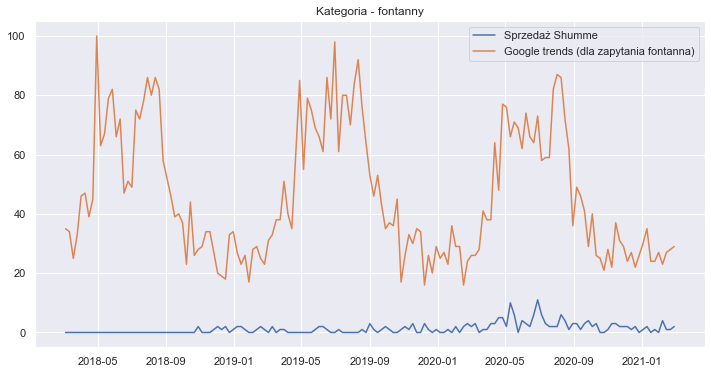

In [133]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))

ax.plot(sells, label = "Sprzedaż Shumme")
ax.plot(pytrends["fontanna"], label = "Google trends (dla zapytania fontanna)")

plt.legend()
plt.title("Kategoria - fontanny")
plt.show()

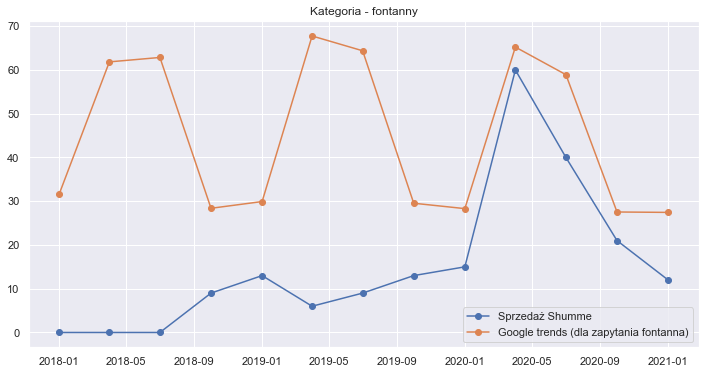

In [140]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))

ax.plot(sells.resample('QS').sum(), label = "Sprzedaż Shumme", marker="o")
ax.plot(pytrends["fontanna"].resample('QS').mean(), label = "Google trends (dla zapytania fontanna)",  marker="o")

plt.legend()
plt.title("Kolejne kwartały. Kategoria - fontanny")
plt.show()

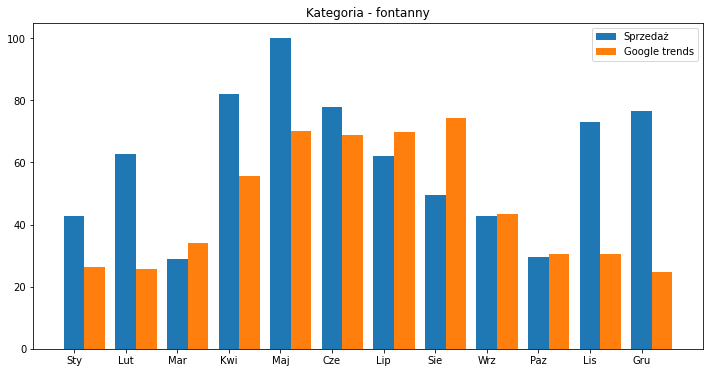

In [61]:
grid = np.array([i + 1.0 for i in range(12)])
width = 0.4
fig, ax = plt.subplots(1, 1, figsize = (12,6))

ax.bar(grid, 100*sells_monthly / sells_monthly.max(), width,
       label = "Sprzedaż", tick_label = "Sty Lut Mar Kwi Maj Cze Lip Sie Wrz Paz Lis Gru".split(" "))

ax.bar(grid + width, pytrends_df.groupby(pytrends_df.index.month)["fontanna"].mean(), width,
       label = "Google trends")

plt.legend()
plt.title("Kategoria - fontanny")
plt.show()